In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
# Only if have GPU enabled tensorflow
# from tensorflow.keras.layers import CuDNNLSTM

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Tips for normalizing data
1. Very important to normalize data for NN
2. Divide by 255.0 instead of 255 to create float dataset from uint8, so that decimals are allowed
3. Can also use sklearn normalization APIs

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"{x_train.shape}, {y_train.shape}, {x_test.shape}, {y_test.shape}")
print(f"{x_train[0].shape}")

print(x_train.dtype)
x_train = x_train/255.0
x_test = x_test/255.0
print(x_train.dtype)

(60000, 28, 28), (60000,), (10000, 28, 28), (10000,)
(28, 28)
uint8
float64


# Using CuDNN optimized versions for faster deep learning training
1. If you have CUDA, use CuDNNLASTM instead and don't use activate='relu', will use default of tanh which is optimized

# Setting of return_sequences in LSTM
1. return_sequences=True returns output as same shape as input. This is useful if feeding into another LSTM which requires shape
2. For return_sequences=False, returns output as a flat shape and this is useful for feeding into Dense or final output value

# Addition of embedding
1. There is also possibly of adding embedding before feeding to LSTM
2. This transforms the sparse vector representation of words into a lower dimensional space to represent words more compactly?

# Usage of input_shape vs batch_input_shape in Keras
1. x_train.shape[1:] turns it from (samples, rows, cols) to (rows, cols) - samples is variable and so is omitted
2. input_shape takes shape as (rows, cols, ...), so can just do input_shape=(x_train.shape[1:])
3. Notice the tuple required for input_shape or batch_input_shape argument

### However, one can also use batch_input_shape=(None, rows, cols, ...)
1. None allows number of samples to be flexible
2. For LSTM, input_shape=(None, None, 1) or (None, None, col) is also allowed if row size is variable, it will automatically pad 0s at the front or end for you?

## Good to write functions for setting up model so that can make many functions for diff models or have one function that generates multiple permutations of models for testing performance
1. In a good pipeline, all steps should be modularized into functions and a final function calling a set of functions from data processing, model setup and training, model evaluation, graph plots and illustrations (as required) and finally saving model into a file

In [4]:
def setup_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    # Notice inner LSTM don't need to specify shape or return sequence
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
lstm_model = setup_model()
# If model summary shows up, means it is successful!
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 128)           80384     
_________________________________________________________________
dropout (Dropout)            (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 213,258
Trainable params: 213,258
Non-trainable params: 0
_________________________________________________________________


# Standard practices of Keras
### Model architecture
1. Using units of 16 for LSTM output units - 16, 32, 64, 128 ... since image is 64x64, good gauge is double of the larger of row/col which 128
2. Dropout of 0.2 works well, but can default to 0 first and try the difference
3. Inner layers generally default to relu for better performance and the range is -1 to 1 (allow for negative units and greater variety of features cancelling each other)
4. Can also try leaky relu to solve dying relu problem (vanishing gradient problem), but result is not consistent
5. Final layer should default to softmax function as it output probability 0-1 (no negative), can try tanh as well
6. Final layer dense shape depends on how many probabilities it needs to output. In this case it is predicting digits 0-9, and shape of output is [sample_count, 10], in model it is Dense(10, ...)
### Optimizer selection
7. Adam optimizer is a very good optimizer to start by default, otherwise can try SGD (gradient descent, stochastic) as well
8. Optimizer need not use decay by default, can add it later on as the training progress might be very slow in the experimental training phase (need increase LR) and decay will slow it down further
9. If using default adam optimizer, don't need to write opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5) and optimizer=opt
10. Decay rate should at least 100 times smaller than the learning rate, unless you are using aggressive learning rate of 0.1 and above
11. Just write model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy']) in one line
### Loss functions for understanding model peformance and graph plotting
12. Common losses include sparse_categorical_crossentropy (for categorical), mean_squared_error/mse and mean_absolute_error/mae
13. Since 0-9 is categorical probabilities with many outcomes, sparse_categorical_crossentropy is commonly used - need to read up more!!
14. metrics=['accuracy'] is most commonly used but Keras provides many alternatives as well, you can put multiple metrics inside, e.g. metrics.MeanSquaredError() and metrics.AUC()
### Other reminders and useful tips
15. Remember to model.compile()! Use model.summary() to see if the model design is correct
16. Using a callback function, the metric values will be saved inside a history variable if you write history = model.fit(). Writing history.history will give access to a dictionary with the metrics result for each Epoch to plot a performance graph - e.g. history.history['loss'] and  history.history['valloss'] shows the loss of the model over training and validation set across epochs
17. You can create your own callback function to link up to the model while it is training on the cloud, provide as an argument to get the performance results via an API to show somewhere (e.g. an app or through Telegram) for your convenience
18. You can also create your own performance function metric to evaluate model performance - https://keras.io/api/callbacks/
```
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
model.fit(dataset, epochs=10, callbacks=my_callbacks)
```
19. Remember to put validation_data=(x_test, y_test) if you want to see validation loss while training.
20. Good number of Epochs vary on the entire dataset size. If dataset is large but highly repetitive (like MNIST that shows just 10 digits), then good to try less epochs (below 5) to see if training loss is falling properly
21. Good number of Epochs range from 100-1000 depending on data
22. Decrease batch_size from 64/128 to 32 or use Google collab if facing ResourceExhaustedError:  OOM when allocating tensor, and/or close other memory intensive windows like other Python programs, notebooks and Chrome pages
23. The higher the batch size the more "stochastic" and jumpy the training error, but training might run more quickly

In [6]:
history = lstm_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=64)

Epoch 1/20
938/938 [==============================] - 104s 111ms/step - loss: 0.5370 - accuracy: 0.8255 - val_loss: 0.1648 - val_accuracy: 0.9471
Epoch 2/20
938/938 [==============================] - 92s 99ms/step - loss: 0.1399 - accuracy: 0.9578 - val_loss: 0.1203 - val_accuracy: 0.9632
Epoch 3/20
938/938 [==============================] - 91s 97ms/step - loss: 0.0950 - accuracy: 0.9714 - val_loss: 0.0606 - val_accuracy: 0.9806
Epoch 4/20
938/938 [==============================] - 93s 99ms/step - loss: 0.0742 - accuracy: 0.9782 - val_loss: 0.0794 - val_accuracy: 0.9759
Epoch 5/20
938/938 [==============================] - 91s 97ms/step - loss: 0.0645 - accuracy: 0.9809 - val_loss: 0.0617 - val_accuracy: 0.9810
Epoch 6/20
938/938 [==============================] - 91s 97ms/step - loss: 0.0539 - accuracy: 0.9836 - val_loss: 0.0394 - val_accuracy: 0.9879
Epoch 7/20
938/938 [==============================] - 91s 97ms/step - loss: 0.0451 - accuracy: 0.9867 - val_loss: 0.0394 - val_accurac

In [7]:
history.history

{'loss': [0.5369547605514526,
  0.13986901938915253,
  0.0949932187795639,
  0.074190653860569,
  0.06446409970521927,
  0.05387952923774719,
  0.04507514834403992,
  0.040916573256254196,
  0.03674032911658287,
  0.03317611664533615,
  0.030829373747110367,
  0.026436077430844307,
  0.0233184602111578,
  0.020970704033970833,
  0.02162044681608677,
  0.018592504784464836,
  0.017645293846726418,
  0.016198454424738884,
  0.014918552711606026,
  0.014814860187470913],
 'accuracy': [0.8254666924476624,
  0.9577999711036682,
  0.9714333415031433,
  0.9782333374023438,
  0.9809333086013794,
  0.9836333394050598,
  0.9866999983787537,
  0.9875666499137878,
  0.9892666935920715,
  0.9901666641235352,
  0.9907666444778442,
  0.9917666912078857,
  0.9932500123977661,
  0.993399977684021,
  0.9939833283424377,
  0.9947500228881836,
  0.9943833351135254,
  0.9947166442871094,
  0.9953166842460632,
  0.9956833124160767],
 'val_loss': [0.1648211032152176,
  0.1203177347779274,
  0.060624610632658

In [8]:
results = lstm_model.predict(x_test)
results_classes = lstm_model.predict_classes(x_test)
# results shape depending on (samples of testing x, number of classes)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


# Since predict classes will be removed after 2021:
WARNING:tensorflow:From <ipython-input-16-9a4f2dc2d328>:2: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

In [9]:
print(f"{results.shape}, {results_classes.shape}")

(10000, 10), (10000,)


In [10]:
results

array([[7.1420976e-09, 6.3108573e-08, 1.4257010e-08, ..., 9.9998474e-01,
        3.7192111e-10, 7.5199341e-07],
       [1.9023133e-14, 1.8150065e-10, 1.0000000e+00, ..., 1.4564430e-12,
        2.6232543e-13, 1.6609481e-16],
       [3.0039109e-14, 1.0000000e+00, 3.9267807e-09, ..., 9.1094915e-10,
        1.0884753e-11, 2.0368254e-13],
       ...,
       [3.0627531e-10, 1.5560879e-10, 7.0619080e-11, ..., 1.8787816e-09,
        6.9912687e-10, 2.3174834e-08],
       [4.4169958e-12, 1.4113454e-11, 7.0562859e-14, ..., 2.0680168e-13,
        1.7466978e-07, 7.8625834e-10],
       [6.2749268e-07, 4.2809015e-10, 7.1760667e-07, ..., 6.5166222e-14,
        6.5858536e-08, 6.6693880e-11]], dtype=float32)

In [11]:
results_classes

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [12]:
# Get max value across the last axis (i.e. the 10 columns since (samples, 10), 10 is last axis)
np.argmax(lstm_model.predict(x_test), axis=-1)

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

# Compare set of numbers that were wrong
## Can also use PIL or plt to show images that were wrong

In [13]:
boolean_accurate_results = results_classes == y_test
print(results_classes[~boolean_accurate_results])
print(y_test[~boolean_accurate_results])
print(f"{boolean_accurate_results.sum()} out of {results_classes.shape[0]} test images predicted correctly")
# 120 digits read wrongly are shown below

[7 4 4 3 9 2 5 2 3 2 4 1 7 2 3 7 5 7 4 5 3 0 9 1 4 0 4 3 1 4 4 5 2 1 5 7 5
 8 1 0 8 2 4 1 4 1 7 4 1 1 2 0 3 5 4 0 4 8 4 5 2 8 3 1 7 3 5 2 2 2 8 7 3 5
 6 5 9 5]
[2 7 9 5 4 8 6 7 9 7 9 7 5 8 2 3 9 0 9 6 5 2 4 6 9 2 2 5 6 9 7 6 3 5 9 9 3
 0 9 6 6 7 9 7 9 7 9 9 7 3 8 6 2 3 9 6 9 0 6 1 7 3 6 7 0 8 8 7 7 7 9 2 6 6
 5 6 4 6]
9922 out of 10000 test images predicted correctly


# Val loss is lower than train loss and val_accuracy higher than train accuracy
1. This occurs because loss is taken to be average across an epoch but val loss is taken only at the end of each epoch
2. If val loss seem to be lower than loss and/or val accuracy higher than accuracy, means model still has potential to learn
3. i.e. Accuracy has yet to reach it's stabilizing region

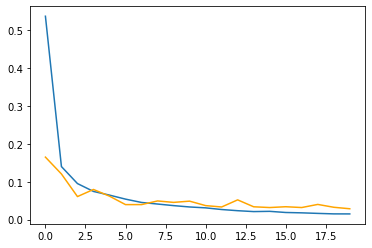

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='orange')
plt.show()

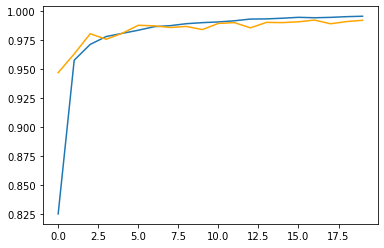

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='orange')
plt.show()

In [16]:
lstm_model.save('lstm_mnist_model.tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lstm_mnist_model.tf\assets
